In [8]:
import matplotlib.pyplot as plt
import skimage.io
import numpy as np
import os
from keras.preprocessing import image
import cv2
# plots in jupyter notebooks
%matplotlib inline

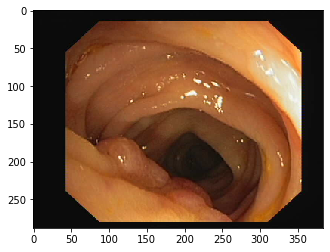

In [9]:
# Load an original image
original = skimage.io.imread('/Users/aleksandrsimonyan/Desktop/Original/1.tif', plugin='tifffile')
plt.imshow(original) # plot image

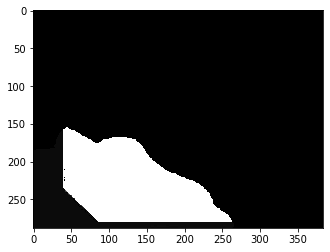

In [10]:
# Load the ground truth image
thruth =image.load_img('/Users/aleksandrsimonyan/Desktop/downloaded/Ground Truth/1.tif')
thruth_array = image.img_to_array(thruth)  # this is a Numpy array
thruth_array = thruth_array * 1./255 # image normalization for keras
plt.imshow(thruth_array)             # plot image

In [14]:
# Define the image folders for the downloaded images = to be processed
OriginalFolder    = '/Users/aleksandrsimonyan/Desktop/Original'
GroundTruthFolder = '/Users/aleksandrsimonyan/Desktop/downloaded/Ground Truth'

# Define the image folders for the cropped images = resulted from this script
PolypsFolder      = '/Users/aleksandrsimonyan/Desktop/cropped/polyps'
nonPolypsFolder   = '/Users/aleksandrsimonyan/Desktop/cropped/non_polyps'

# Minimum box to crop for non-polyp images
min_box = 150 # get box of 150 x 150 pixels

In [16]:
orFiles = os.listdir(OriginalFolder)
gtFiles = os.listdir(GroundTruthFolder)
print('Original files:', OriginalFolder, len(orFiles), '\nGround Truth files:', GroundTruthFolder, len(gtFiles))

Original files: /Users/aleksandrsimonyan/Desktop/Original 612 
Ground Truth files: /Users/aleksandrsimonyan/Desktop/downloaded/Ground Truth 612


In [18]:
# Crop polys as new images
print('--> Cropping polyps as images ...')
# For each image in Original folder
for iFile in orFiles:
    # Get full path for original / source image = folder + filename
    sourceFile = os.path.join(OriginalFolder,iFile)
    # Get full path for polyp location image = folder + filename
    locationFile = os.path.join(GroundTruthFolder,iFile)
    # Get full path for polyp cropped image = folder + filename
    polypFile = os.path.join(PolypsFolder,iFile)
    # Get full path for non-polyp cropped image = folder + filename
    nonpolypFile = os.path.join(nonPolypsFolder,iFile)
    
    # Read the original image
    img_o_array = skimage.io.imread(sourceFile, plugin='tifffile') # array with pixel data
    # Remove black margins using manual values from trials
    img_o_array = img_o_array[30:280,90:220+90,:]
    
    # Read ground truth image
    img_gt_array = cv2.imread(locationFile)
#    img_gt_array = img_to_array(img_gt)  # this is a Numpy array
    img_gt_array = img_gt_array * 1./255 # image normalization for keras
    # Remove the black margins
    img_gt_array = img_gt_array[30:280,90:220+90,:]
    
    # Apply mask for ground truth image: find non-black pixels!
    mask = img_gt_array > [0,0,0] # using 3 channels
    # Get coordinates of non-black pixels using only one channel data!
    coords = np.argwhere(mask[:,:,0])
    # Set bounding box of non-black pixels (used to define the polyp cropping area)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get the cropped image with a polyp from the original image
    cropped = img_o_array[x0:x1, y0:y1,:]
    
    # SAVE the croped image as a polyp image in 'cropped/1-Polyps' (jpg format)
    plt.imsave(polypFile[:-4]+'.jpg', cropped)

print('Done!')

--> Cropping polyps as images ...
Done!


In [20]:
# Crop non-polys as new images (one image for each polyp)
print('--> Cropping non-polyps as images ...')
# For each image in Original folder
for iFile in orFiles:
    # Get full path for original / source image = folder + filename
    sourceFile = os.path.join(OriginalFolder,iFile)
    # Get full path for polyp location image = folder + filename
    locationFile = os.path.join(GroundTruthFolder,iFile)
    # Get full path for polyp cropped image = folder + filename
    polypFile = os.path.join(PolypsFolder,iFile)
    # Get full path for non-polyp cropped image = folder + filename
    nonpolypFile = os.path.join(nonPolypsFolder,iFile)
    
    # Read the original image
    img_o_array = skimage.io.imread(sourceFile, plugin='tifffile') # array with pixel data
    # Remove black margins using manual values from trials
    img_o_array = img_o_array[30:280,90:220+90,:]
    
    # Read ground truth image
    img_gt_array = cv2.imread(locationFile)
    img_gt_array = img_gt_array * 1./255 # image normalization for keras
    # Remove the black margins
    img_gt_array = img_gt_array[30:280,90:220+90,:]
    
    # Apply mask for ground truth image: find non-black pixels!
    mask = img_gt_array > [0,0,0] # using 3 channels
    # Get coordinates of non-black pixels using only one channel data!
    coords = np.argwhere(mask[:,:,0])
    # Set bounding box of non-black pixels (used to define the polyp cropping area)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get one of the 4 images from left, right, up and bottom to the polyp
    # Get original image x, y (image dimension)
    x, y, ch = img_o_array.shape
    
    
    # Get one section fron up or down (relative to the polyp)
    if (x - x1) > x0:
        x_i = x1
        x_f = x
        y_i = 0
        y_f = y
    else:
        x_i = 0
        x_f = x0
        y_i = 0
        y_f = y
    up_down = img_o_array[x_i:x_f,y_i:y_f,:]
    
    # Get one section fron left or rigth (relative to the polyp)
    if (y - y1) > y0:
        y_i = y1
        y_f = y
        x_i = 0
        x_f = x
    else:
        y_i = 0
        y_f = y0
        x_i = 0
        x_f = x
        
    left_right = img_o_array[x_i:x_f,y_i:y_f,:]
    
    # If area of up_down image is greater than left_right, save as non_polyp the up_down image; else save left-right
    surface_up_down    = up_down.shape[0] * up_down.shape[1]
    surface_left_right = left_right.shape[0] * left_right.shape[1]
    if surface_up_down > surface_left_right:
        non_polyp = up_down
    else:
        non_polyp = left_right
    # If surface of the result is different of zero, save it!
    surface_non_polyp = non_polyp.shape[0] * non_polyp.shape[1]
    if surface_non_polyp!=0:
        plt.imsave(nonpolypFile[:-4]+'.jpg', non_polyp)
    else:
        # If non-polyp area is zero print an error message
        print('Without non-polys:', nonpolypFile)

print("Done!")

--> Cropping non-polyps as images ...
Without non-polys: /Users/aleksandrsimonyan/Desktop/cropped/non_polyps/478.tif
Without non-polys: /Users/aleksandrsimonyan/Desktop/cropped/non_polyps/22.tif
Without non-polys: /Users/aleksandrsimonyan/Desktop/cropped/non_polyps/490.tif
Done!


In [21]:
# Remove a specific list of files from cropped polyps
for iFileToRemove in [55, 67, 178, 329, 559, 82]:
    # Get full path for polyp cropped image = folder + filename
    polypFile = os.path.join(PolypsFolder,str(iFileToRemove)+'.jpg')
    try:
        print("--> Removing file:", polypFile)
        os.remove(polypFile)
    except:
        print("----> Error:", polypFile, "do not exists!")

--> Removing file: /Users/aleksandrsimonyan/Desktop/cropped/polyps/55.jpg
--> Removing file: /Users/aleksandrsimonyan/Desktop/cropped/polyps/67.jpg
--> Removing file: /Users/aleksandrsimonyan/Desktop/cropped/polyps/178.jpg
--> Removing file: /Users/aleksandrsimonyan/Desktop/cropped/polyps/329.jpg
--> Removing file: /Users/aleksandrsimonyan/Desktop/cropped/polyps/559.jpg
--> Removing file: /Users/aleksandrsimonyan/Desktop/cropped/polyps/82.jpg


In [22]:
# Remove a specific list of files from cropped non-polyps
for iFileToRemove in [25, 476, 477]:
    # Get full path for polyp cropped image = folder + filename
    nonpolypFile = os.path.join(nonPolypsFolder,str(iFileToRemove)+'.jpg')
    try:
        print("--> Removing file:", nonpolypFile)
        os.remove(nonpolypFile)
    except:
        print("----> Error:", nonpolypFile, "do not exists!")

--> Removing file: /Users/aleksandrsimonyan/Desktop/cropped/non_polyps/25.jpg
--> Removing file: /Users/aleksandrsimonyan/Desktop/cropped/non_polyps/476.jpg
--> Removing file: /Users/aleksandrsimonyan/Desktop/cropped/non_polyps/477.jpg


In [23]:
print('Cropped polyps:', len(os.listdir(PolypsFolder)), '\nCropped non-polyps:', len(os.listdir(nonPolypsFolder)))

Cropped polyps: 606 
Cropped non-polyps: 606


/Users/aleksandrsimonyan/Desktop/cropped/polyps/.jpg


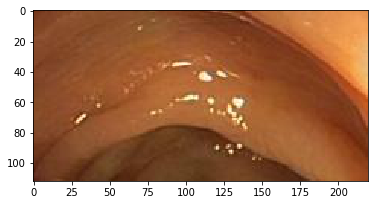

In [38]:
one_nonpolyp = skimage.io.imread(nonpolypFile[:-6]+'.jpg')
print(polypFile[:-6]+'.jpg')
plt.imshow(one_nonpolyp) # plot image

# Split polyps / non-polyps dataset
Use polyps and non_polyps from cropped to copy files into train and validation from data_polyps. This folder should already exists and have both subfolders (or ajust the script to create them). The current data_polyps folder will be the dataset folder for the next deep learning classifications.

Therefore, we shall use a dataset split percentage such as 75% train and 25% test.

We need os and shutil to manage the files, random to randomly split the dataset in train and validation subsets. You should have a folder structure such as:

./data_polyps/train/polyps
./data_polyps/train/non_polyps
./data_polyps/validation/polyps
./data_polyps/validation/non_polyps

In [39]:
import os
import random
import shutil

In [40]:
# Source dataset: from where to copy the files
sourceFolderClass1 = '/Users/aleksandrsimonyan/Desktop/cropped/polyps'
sourceFolderClass2 = '/Users/aleksandrsimonyan/Desktop/cropped/non_polyps'
# Destination folders: splitted dataset in train and validation for polyps and non-polyps
destFolderClass1_tr  = '/Users/aleksandrsimonyan/Desktop/cropped/train/polyps'
destFolderClass2_tr  = '/Users/aleksandrsimonyan/Desktop/cropped/train/non_polyps'
destFolderClass1_val = '/Users/aleksandrsimonyan/Desktop/cropped/validation/non_polyps'
destFolderClass2_val = '/Users/aleksandrsimonyan/Desktop/cropped/validation/polyps'

In [41]:
sourceFiles1 = os.listdir(sourceFolderClass1)
sourceFiles2 = os.listdir(sourceFolderClass2)
print("Class 1 - polyps:", len(sourceFiles1))
print("Class 2 - non-polyps:", len(sourceFiles2))

Class 1 - polyps: 606
Class 2 - non-polyps: 606


In [42]:
random.seed(1)
random.shuffle(sourceFiles1)
random.shuffle(sourceFiles2)

In [45]:
# No of file to copy in VALIDATION folder for each class
val_files = 151

# Copy the first 151 files for polyps and non-polyps into validation folders
print('--> Validation split ...')
for i in range(val_files):
    # copy validation polyps
    File1 = os.path.join(sourceFolderClass1,sourceFiles1[i])
    File2 = os.path.join(destFolderClass1_val,  sourceFiles1[i])
    shutil.copy(File1,File2)
    # copy validation non-polyps
    File1 = os.path.join(sourceFolderClass2, sourceFiles2[i])
    File2 = os.path.join(destFolderClass2_val,   sourceFiles2[i])
    shutil.copy(File1, File2)

print('--> Done!')

--> Validation split ...
--> Done!


In [47]:
# Copy polyps to train
print('--> Train split ...')
for i in range(val_files,len(sourceFiles1)):
    File1 = os.path.join(sourceFolderClass1,  sourceFiles1[i])
    File2 = os.path.join(destFolderClass1_tr, sourceFiles1[i])
    shutil.copy(File1,File2)
# copy non-polyps to train
for i in range(val_files,len(sourceFiles2)):    
    File1 = os.path.join(sourceFolderClass2,  sourceFiles2[i])
    File2 = os.path.join(destFolderClass2_tr, sourceFiles2[i])
    shutil.copy(File1, File2)

print('--> Done!')

--> Train split ...
--> Done!


In [48]:
print('--> Dataset: data_polyps')
print('> Train - polyps:', len(os.listdir(destFolderClass1_tr)))
print('> Train - non-polyps:', len(os.listdir(destFolderClass2_tr)))
print('> Validation - polyps:', len(os.listdir(destFolderClass1_val)))
print('> Validation - non-polyps:', len(os.listdir(destFolderClass2_val)))

--> Dataset: data_polyps
> Train - polyps: 455
> Train - non-polyps: 455
> Validation - polyps: 151
> Validation - non-polyps: 151
